<a href="https://colab.research.google.com/github/Shurui-Zhang/Deep_learning/blob/main/Lab2ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import Tuple
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def gd_factorise_ad(A:torch.Tensor, rank:int, num_epochs =1000, lr =0.01) -> Tuple[torch.Tensor, torch. Tensor]:
  m, n = A.shape

  U = torch.tensor(torch.normal(0, 1, size=(m, rank)), requires_grad=True)
  V = torch.tensor(torch.normal(0, 1, size=(n, rank)), requires_grad=True)

  for epoch in range(num_epochs):
    U.grad = None
    V.grad = None

    z = torch.nn.functional.mse_loss(U@V.t(), A, reduction='sum')
    z.backward()

    U.data = U - U.grad * lr
    V.data = V - V.grad * lr
  return U, V


In [ ]:
a = torch.tensor([[0.3374, 0.6005, 0.1735], [3.3359, 0.0492, 1.8374], [2.9407, 0.5301, 2.2620]], dtype=torch.float)
print(np.linalg.matrix_rank(a))
U, V = gd_factorise_ad(a, 2)
print("U = ", U)
print("V = ", V)
print(U @ V.t())
print("error =", torch.nn.functional.mse_loss(U@V.t(), a, reduction='sum'))

3
U =  tensor([[ 0.4835,  0.3864],
        [-0.8797,  1.1379],
        [-0.1880,  1.4209]], requires_grad=True)
V =  tensor([[-1.1252,  1.9890],
        [ 0.6699,  0.5098],
        [-0.3972,  1.4272]], requires_grad=True)
tensor([[ 0.2244,  0.5208,  0.3594],
        [ 3.2532, -0.0091,  1.9735],
        [ 3.0376,  0.5985,  2.1025]], grad_fn=<MmBackward>)
error = tensor(0.1219, grad_fn=<MseLossBackward>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


In [ ]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)  
data = torch.tensor(df.iloc[:, [0,1,2,3]].values)
data = data - data.mean(dim = 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


the reconstruction loss of using gd_factorise_ad: tensor(15.2289, dtype=torch.float64, grad_fn=<MseLossBackward>)
the reconstruction loss of using truncated SVD: tensor(15.2288, dtype=torch.float64)


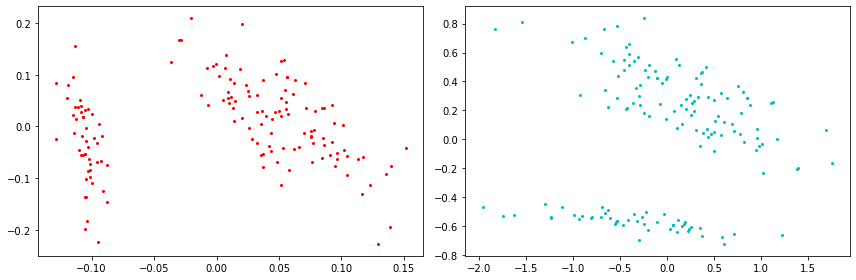

In [ ]:
U, V = gd_factorise_ad(data.float(), 2)
#print("U = ", U)
#print("V = ", V)
print("the reconstruction loss of using gd_factorise_ad:", torch.nn.functional.mse_loss(U@V.t(), data, reduction='sum'))

data_svd = torch.svd(data.float())
data_svd[1][2] = 0
data_svd[1][3] = 0
print("the reconstruction loss of using truncated SVD:", torch.nn.functional.mse_loss(data_svd[0] @ torch.diag(data_svd[1]) @ data_svd[2].t(), data, reduction='sum'))

U1 = U.detach().numpy()
U2 = data_svd[0]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[1].scatter(U1[:, 0], U1[:, 1], c='c', s=4)
ax[0].scatter(U2[:, 0], U2[:, 1], c='r', s=4)
plt.tight_layout()
plt.savefig('svd-U^.png')

In [ ]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None) 
df = df.sample(frac = 1)#shuffle

#add lable indices column
mapping = {k: v for v, k in enumerate(df[4].unique())}
df[5] = df[4].map(mapping)

#normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float) 

#create datasets
targets_tr = torch.tensor(df.iloc[:100, 5].values, dtype = torch.long)
targets_va = torch.tensor(df.iloc[100:, 5].values, dtype = torch.long)

data_tr = alldata[:100]
data_va = alldata[100:]

print(targets_tr.shape)

torch.Size([100])


In [ ]:
def mlp(A:torch.Tensor, num_epochs =100, lr =0.01) -> Tuple[torch.Tensor, torch. Tensor]:
  w1 = torch.tensor(torch.normal(0, 1, size=(4, 12)), requires_grad=True)
  w2 = torch.tensor(torch.normal(0, 1, size=(12, 3)), requires_grad=True)
  b1 = torch.tensor(0.0, requires_grad=True)
  b2 = torch.tensor(0.0, requires_grad=True)

  for epoch in range(num_epochs):
    w1.grad = None
    w2.grad = None
    b1.grad = None
    b2.grad = None

    logits = torch.relu(A @ w1 + b1) @ w2 + b2
    error = torch.nn.functional.cross_entropy(logits, targets_tr)
    error.backward()

    w1.data = w1 - w1.grad * lr
    w2.data = w2 - w2.grad * lr
    b1.data = b1 - b1.grad * lr
    b2.data = b2 - b2.grad * lr
  return w1, w2, b1, b2

In [ ]:
for i in range(10):
  w1, w2, b1, b2 = mlp(data_tr)
  predict = torch.relu(data_tr @ w1 + b1) @ w2 + b2
  print("the cross-entropy loss on the training set:", torch.nn.functional.cross_entropy(predict, targets_tr))
  predict_va = torch.relu(data_va @ w1 + b1) @ w2 + b2
  print("the cross-entropy loss on the validation set:",torch.nn.functional.cross_entropy(predict_va, targets_va))
  print("next epoch")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


the cross-entropy loss on the training set: tensor(0.2450, grad_fn=<NllLossBackward>)
the cross-entropy loss on the validation set: tensor(0.2354, grad_fn=<NllLossBackward>)
next epoch
the cross-entropy loss on the training set: tensor(0.6323, grad_fn=<NllLossBackward>)
the cross-entropy loss on the validation set: tensor(0.5867, grad_fn=<NllLossBackward>)
next epoch
the cross-entropy loss on the training set: tensor(0.2528, grad_fn=<NllLossBackward>)
the cross-entropy loss on the validation set: tensor(0.2276, grad_fn=<NllLossBackward>)
next epoch
the cross-entropy loss on the training set: tensor(0.8831, grad_fn=<NllLossBackward>)
the cross-entropy loss on the validation set: tensor(1.1003, grad_fn=<NllLossBackward>)
next epoch
the cross-entropy loss on the training set: tensor(0.3050, grad_fn=<NllLossBackward>)
the cross-entropy loss on the validation set: tensor(0.2761, grad_fn=<NllLossBackward>)
next epoch
the cross-entropy loss on the training set: tensor(0.1432, grad_fn=<NllLoss